# Домашнее задание

Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Импорт библиотек и загрузка данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,  kpss

%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

In [ ]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [ ]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Оставим только данные по городу Бангалор

In [ ]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [ ]:
# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [ ]:
ts.head()

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


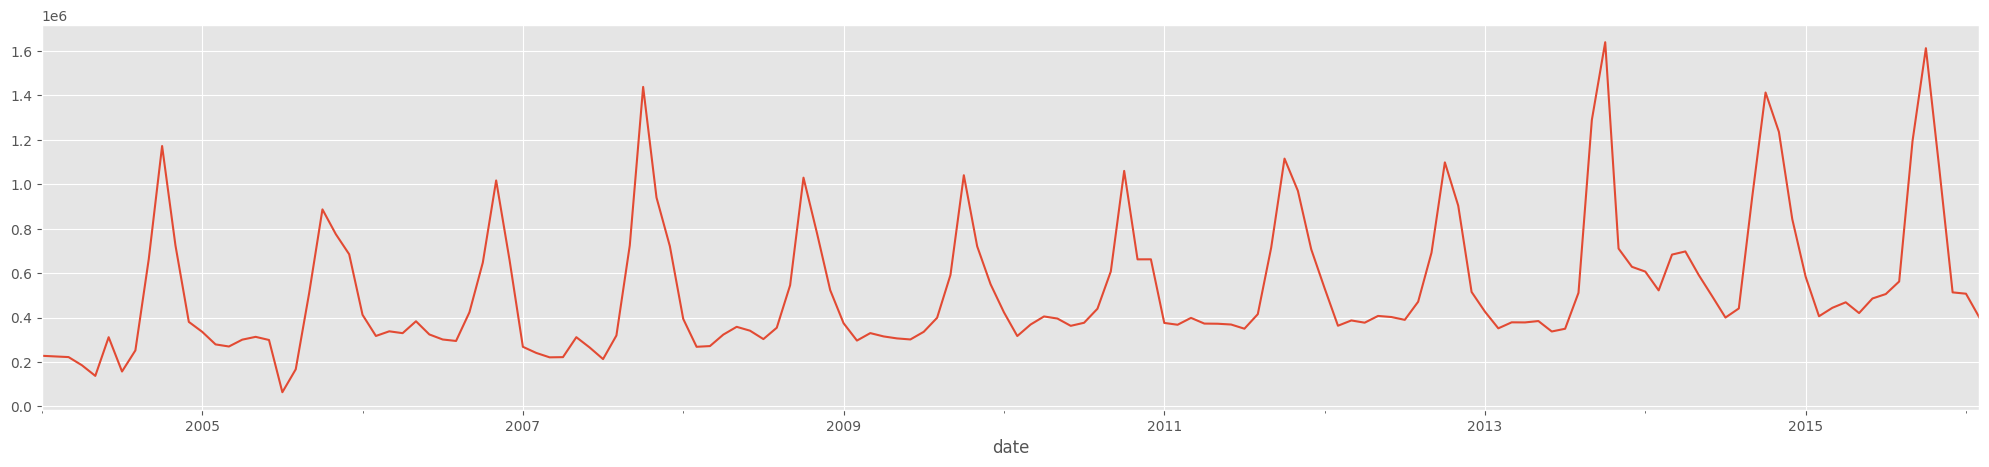

In [ ]:
ts.quantity.plot(figsize=(25,5));

## Quiz

Примените критерий Дики-Фуллера

Есть ли в ряде единичные корни?

In [ ]:
def d_full(ts):
  adf = adfuller(ts)
  if adf[1] < 0.05:
    print('Ряд Стационарен')
  else :
    print('Ряд не стационарен ')

d_full(ts)



Ряд не стационарен 


## Quiz

Примените kpss-тест

Является ли ряд стационарным?

In [ ]:
def d_full_kpss(ts):
  kpss_value = kpss(ts)
  if kpss_value[1] < 0.05:
    print('Ряд Не стационарен ')
  else :
    print('Стационарен')
d_full_kpss(ts)

Ряд Не стационарен 


<ipython-input-60-e2f2df22ec89>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_value = kpss(ts)


## Quiz

Найдите оптимальное $\lambda$ для преобразования Бокса-Кокса

(отрицательные значения говорят о том, что нужно просто логарифмировать ряд - в этом случае считайте, что $\lambda=0$)

Ответ при необходимости округлите до сотых.

In [ ]:
from copy import deepcopy
from scipy import stats

ts_boxcox = deepcopy(ts)

stats.boxcox(ts_boxcox['quantity'])[1]

-0.037973894835219395

Примените преобразование Бокса-Кокса с найденным значением $\lambda$. Далее работайте с преобразованным рядом (и к исходному не возвращайтесь!)

In [ ]:
ts_boxcox['box_quantity'] = stats.boxcox(ts_boxcox['quantity'])[0]
ts_boxcox = ts_boxcox.drop(['quantity'], axis=1)

<Axes: xlabel='date'>

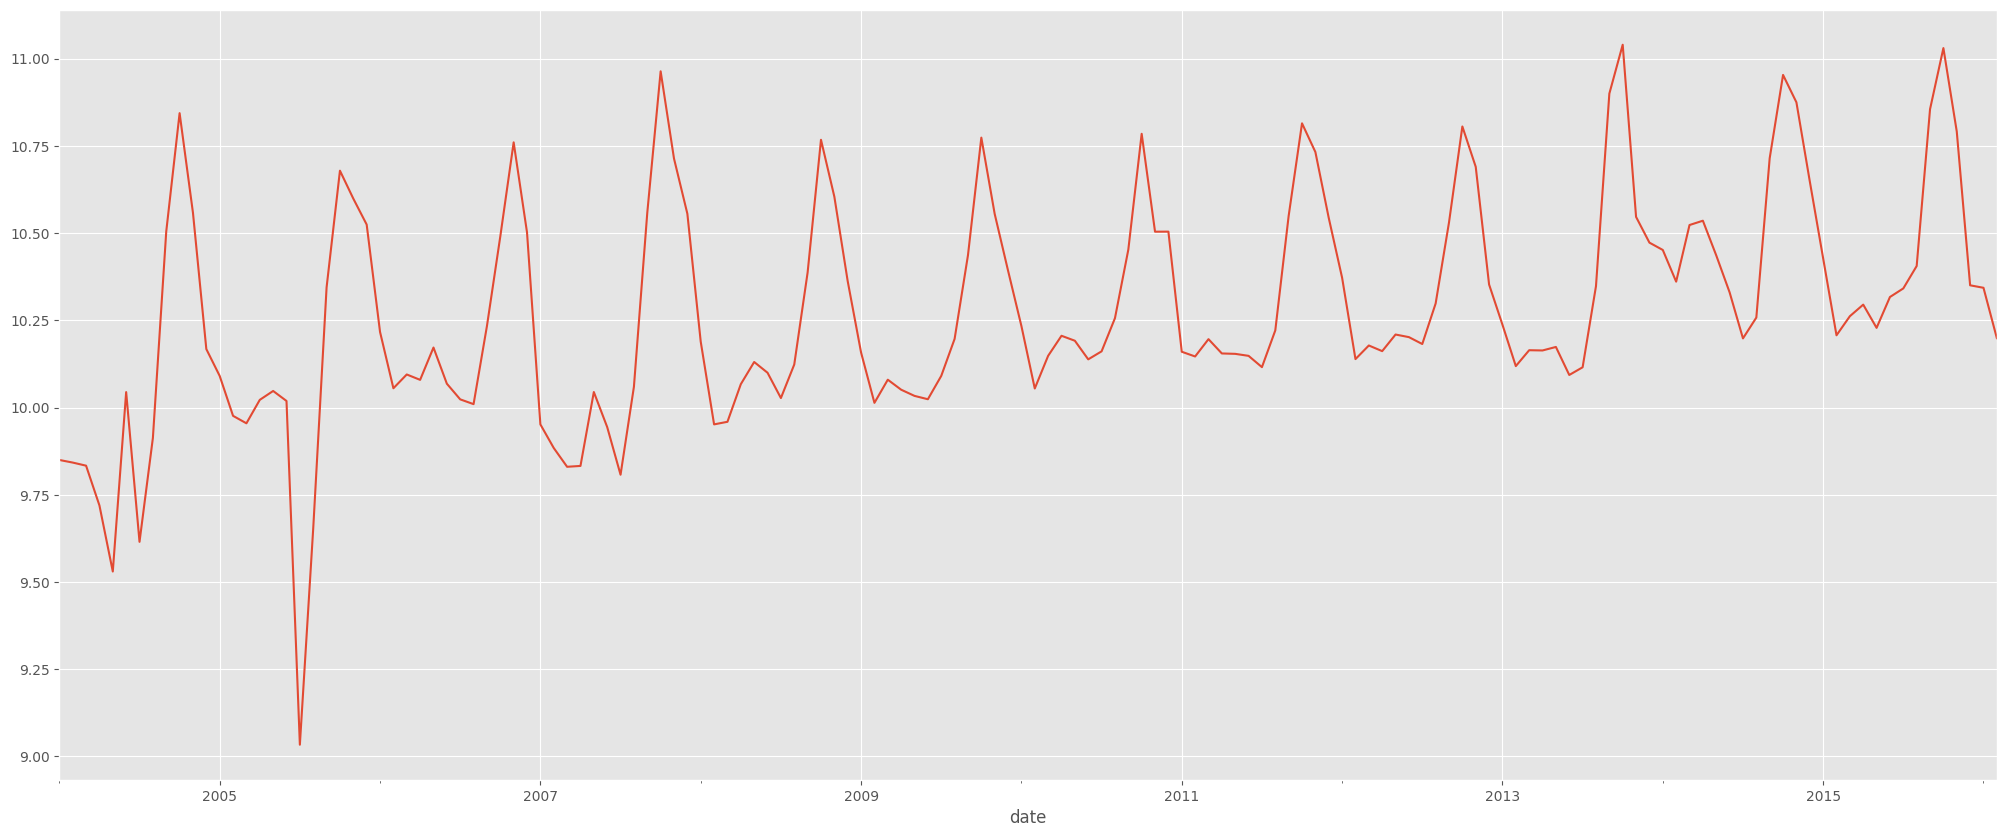

In [ ]:
ts_boxcox['box_quantity'].plot(figsize=(25,10))

<Axes: xlabel='date'>

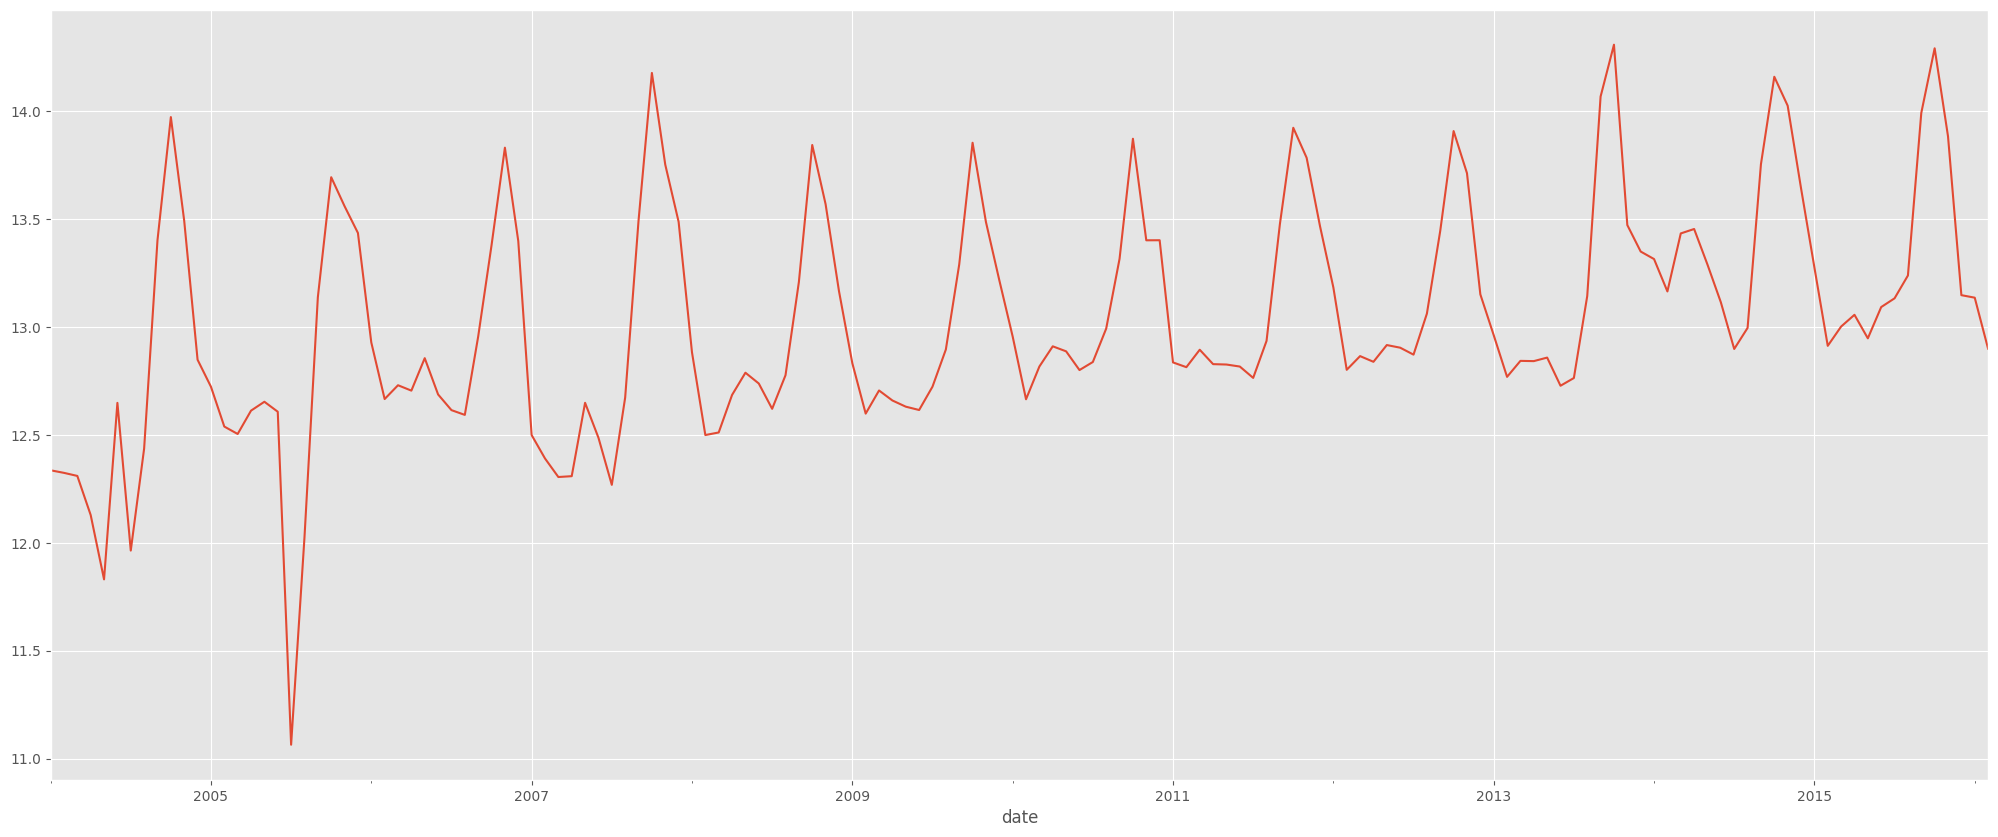

In [ ]:

np.log(ts['quantity']).plot(figsize=(25,10))

## Quiz

Постройте измененный ряд. Стала ли дисперсия более однородной визуально?

In [ ]:
ts_boxcox

,quantity,box_quantity
date,,
2004-01,227832,9.85
2004-02,225133,9.84
2004-03,221952,9.83
2004-04,185150,9.72
2004-05,137390,9.53
...,...,...
2015-10,1612160,11.03
2015-11,1071872,10.79
2015-12,513186,10.35


## Quiz

Визуально в ряде есть небольшой возрастающий тренд.

Продифференцируйте ряд и примените к результату kpss-тест.

Стал ли ряд стационарным?

<Axes: xlabel='date'>

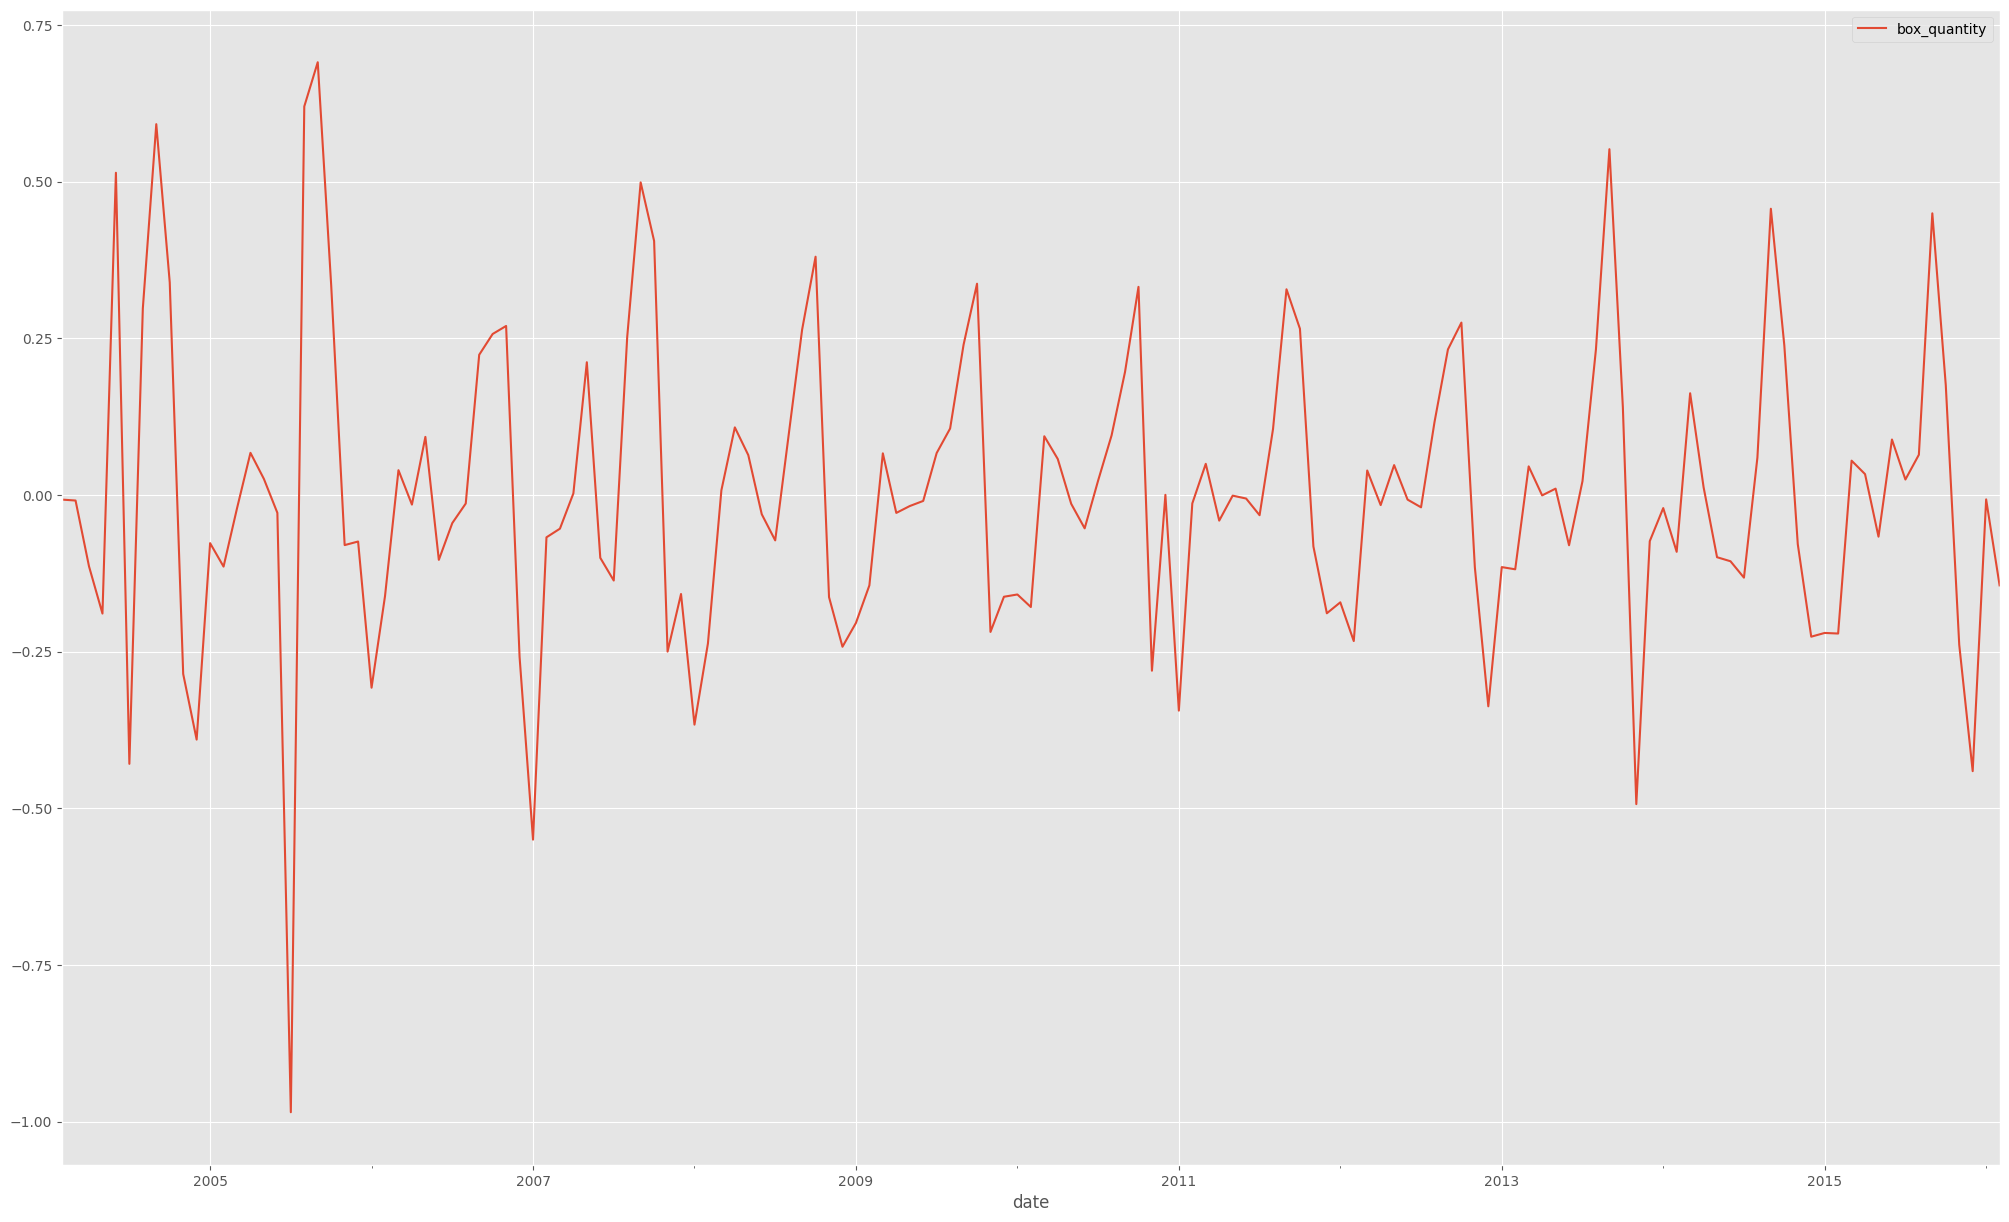

In [ ]:
ts_boxcox = (ts_boxcox - ts_boxcox.shift(1))[1:]

ts_boxcox.plot(figsize=(25,15))

In [ ]:
d_full(ts_boxcox)
d_full_kpss(ts_boxcox)

Ряд Стационарен
Стационарен


<ipython-input-60-e2f2df22ec89>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_value = kpss(ts)


Для продифференцированного ряда постройте графики ACF и PACF.

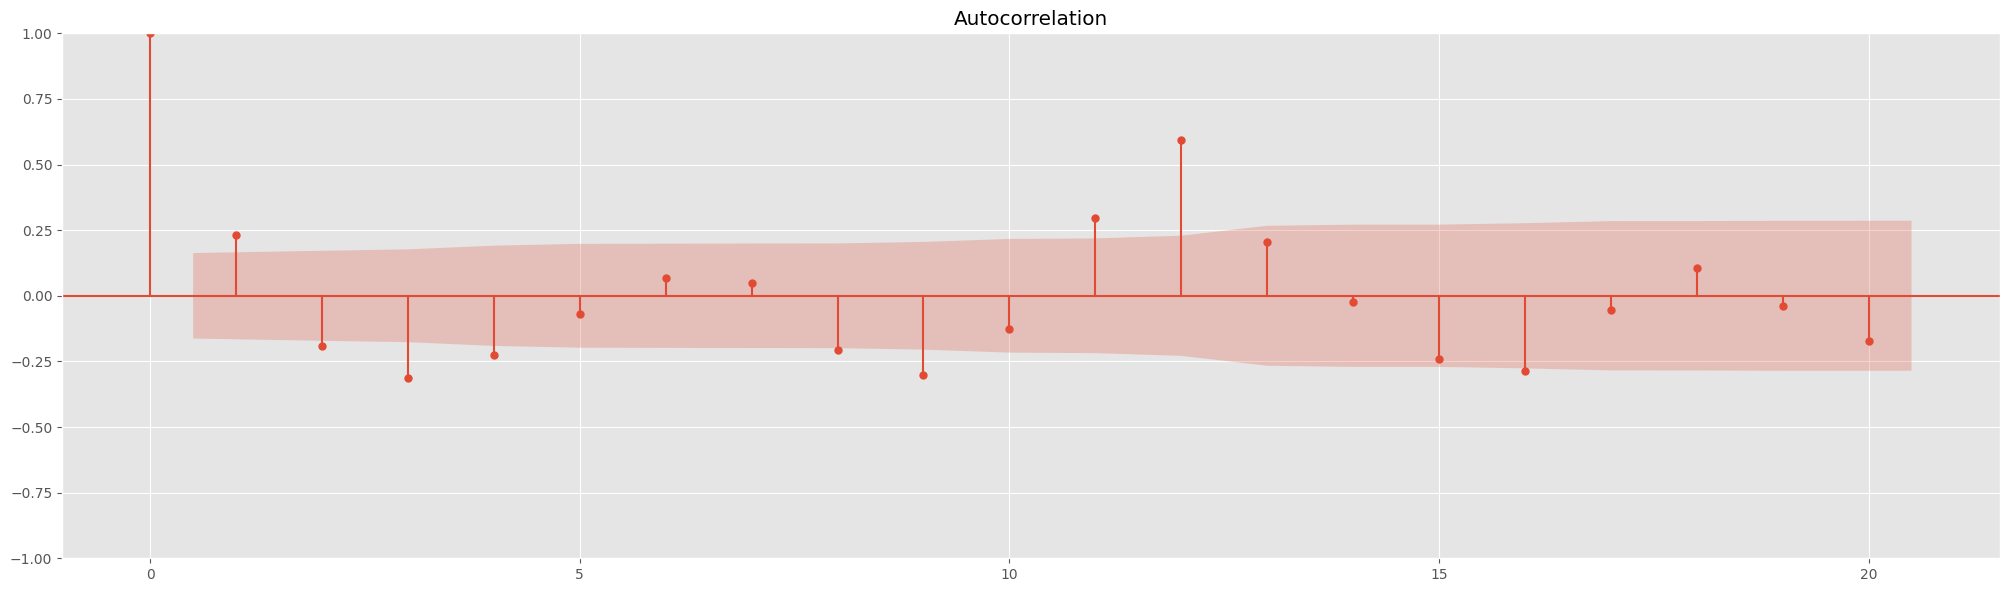

In [ ]:
fig = plt.figure(figsize=(25, 15))

ax = plt.subplot(211)

fig = sm.graphics.tsa.plot_acf(ts_boxcox, ax=ax, lags=20)

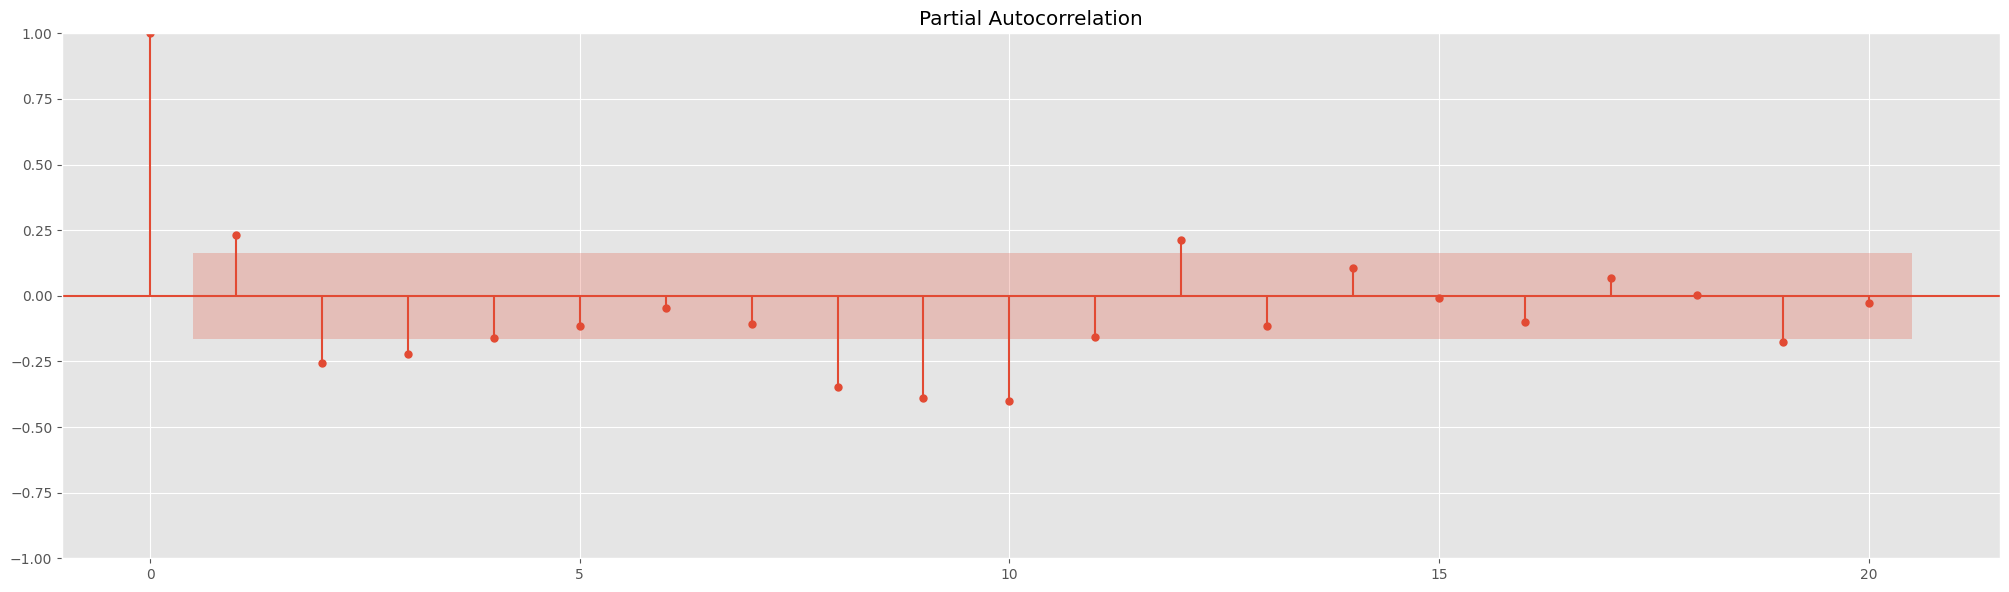

In [ ]:
fig = plt.figure(figsize=(25, 15))

ax = plt.subplot(211)

fig = fig = sm.graphics.tsa.plot_pacf(ts_boxcox, ax=ax, lags=20)

## Quiz

По построенным графикам определите значения $p$ и $q$ для модели ARIMA/SARIMAX.

В диапазоны значений входят все значения от 0 до максимального значимого лага за период (сам лаг периода уже не учитывается).

Подсказка: по графикам диапазоны значений $p$ и $q$ получаются одинаковыми. Чему равно максимальное значение из полученного диапазона.

## Обучение модели SARIMAX

Разобъем данные на train, val, test.

* train - первые 65% данных

* val - следующие 20% данных

* test - последние 15% данных

In [ ]:
train_length = int(len(ts_boxcox) * 0.65)
val_length = int(len(ts_boxcox) * 0.2)

ts_log = np.log(ts)
train = ts_log[:train_length]
val = ts_log[train_length:train_length+val_length]
test = ts_log[train_length+val_length:]

train.shape, val.shape, test.shape

((94, 1), (29, 1), (23, 1))

## Quiz

Среди найденных диапазонов $p$ и $q$ подберите оптимальную тройку $(p,d,q)$ ($d$ нашли выше, когда дифференцировали ряд и смотрели на результат) с помощью вложенного цикла.

В цикле обучайте модель SARIMAX на train и смотрите AIC на val.

In [ ]:
best_score, best_params = float('inf'), None

for p in range(12):
  for q in range(12):
    order = (p, 1, q)
    model = sm.tsa.statespace.SARIMAX(train['quantity'], order=order).fit()
    y_hat_val = model.predict(val.index[0], val.index[-1])
    if model.aic < best_score:
      best_score, best_params = model.aic, (p, 1, q)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

In [ ]:
best_score, best_params

(38.39034866840777, (11, 1, 3))

## Quiz

Обучите на train модель с найденными (p,d,q), выведите на экран AIC - ответ округлите до сотых.

In [ ]:
model = sm.tsa.SARIMAX(train['quantity'], order=best_params,).fit()

round(model.aic, 2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


38.39

Сделайте прогноз на **test**.

In [ ]:
y_hat = model.predict(len(train)+ len(val), len(train) +len(val) + len(test) - 1)
y_hat.values

array([12.90699478, 12.90321514, 12.77938826, 12.83293541, 13.02219544,
       13.23434714, 13.44393786, 13.49233179, 13.40515052, 13.17765996,
       13.05969948, 12.99902084, 12.93103155, 12.90094168, 12.81507863,
       12.86490119, 12.99827359, 13.17812794, 13.38414948, 13.44046874,
       13.37145587, 13.21576754, 13.11000549])

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

## Quiz

Нарисуйте правильный ответ на test и прогноз на test. Вычислите RMSE на test. Ответ округлите до сотых.

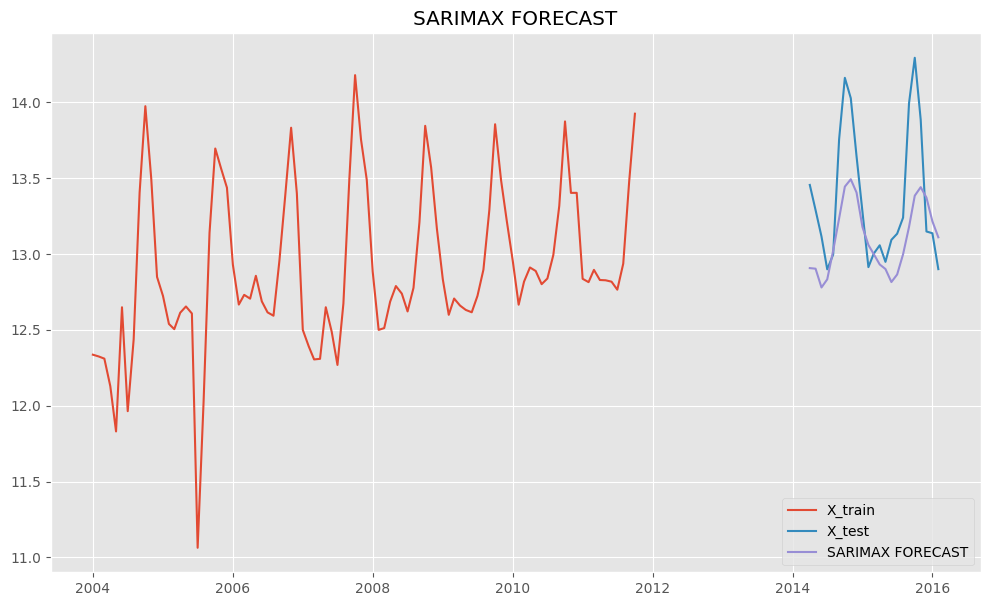

rmse : 0.4


In [ ]:

plt.figure(figsize=(12, 7))


plt.plot(train.index.to_timestamp(), train['quantity'].values, label='X_train')
plt.plot(test.index.to_timestamp(), test['quantity'].values, label='X_test')

plt.plot(y_hat.index.to_timestamp(), y_hat.values, label='SARIMAX FORECAST')

plt.legend(loc='best')

plt.title('SARIMAX FORECAST')
plt.show()
print(f'rmse : {round(np.sqrt(mean_squared_error(test, y_hat)), 2)}')

По графикам ACF и PACF определите примерные диапазоны для P и Q, найдите S.

Нулевые значения также рассматривайте.

Зафиксируйте найденные ранее (p,d,q). Подберите в цикле аналогично подбору для $p, q$ оптимальные значения из найденных диапазонов.

D перебирайте в диапазоне {0, 1}.

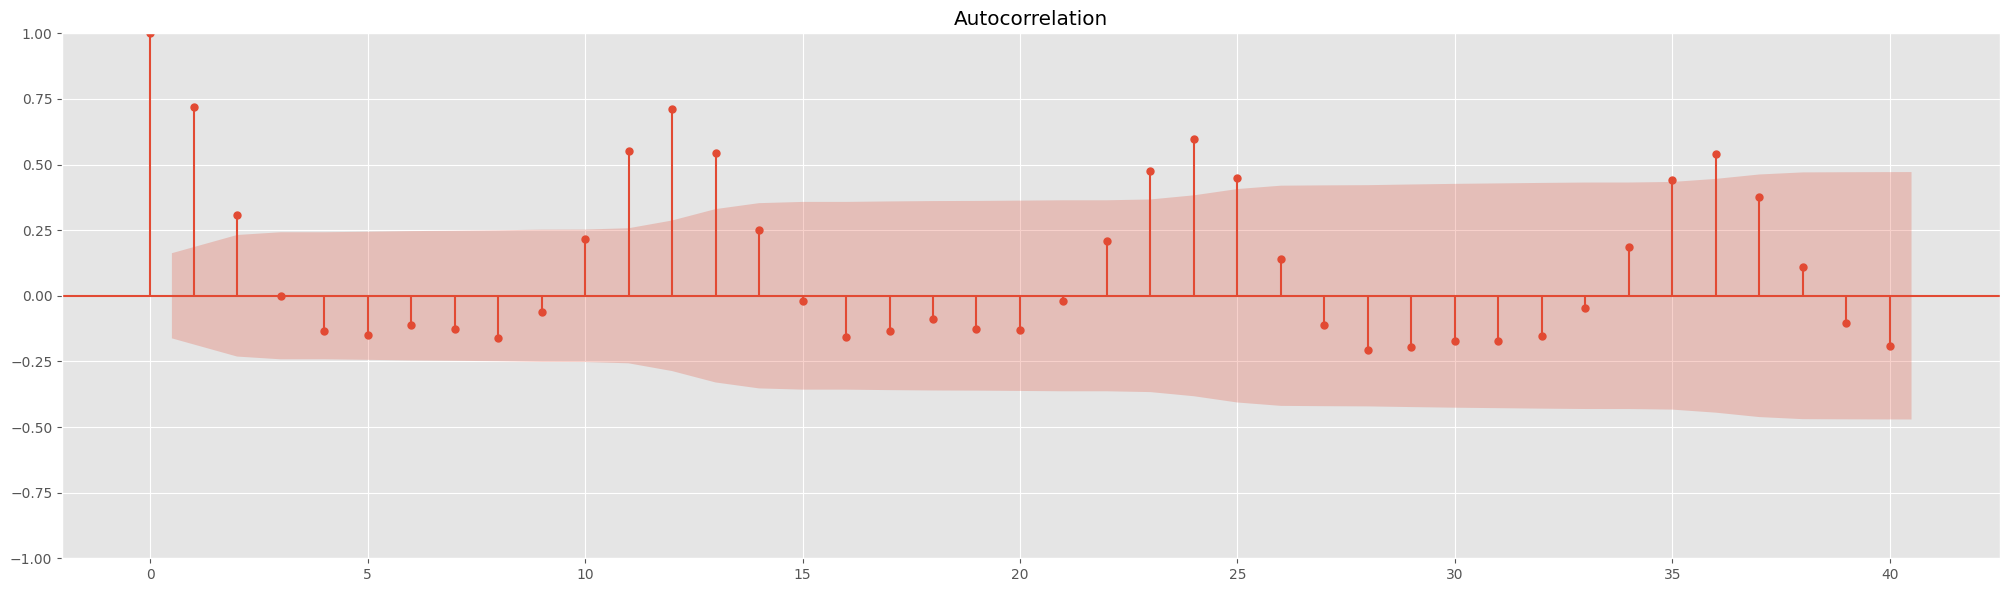

In [ ]:
fig = plt.figure(figsize=(25, 15))

ax = plt.subplot(211)

fig = sm.graphics.tsa.plot_acf(ts_log, ax=ax, lags=40)

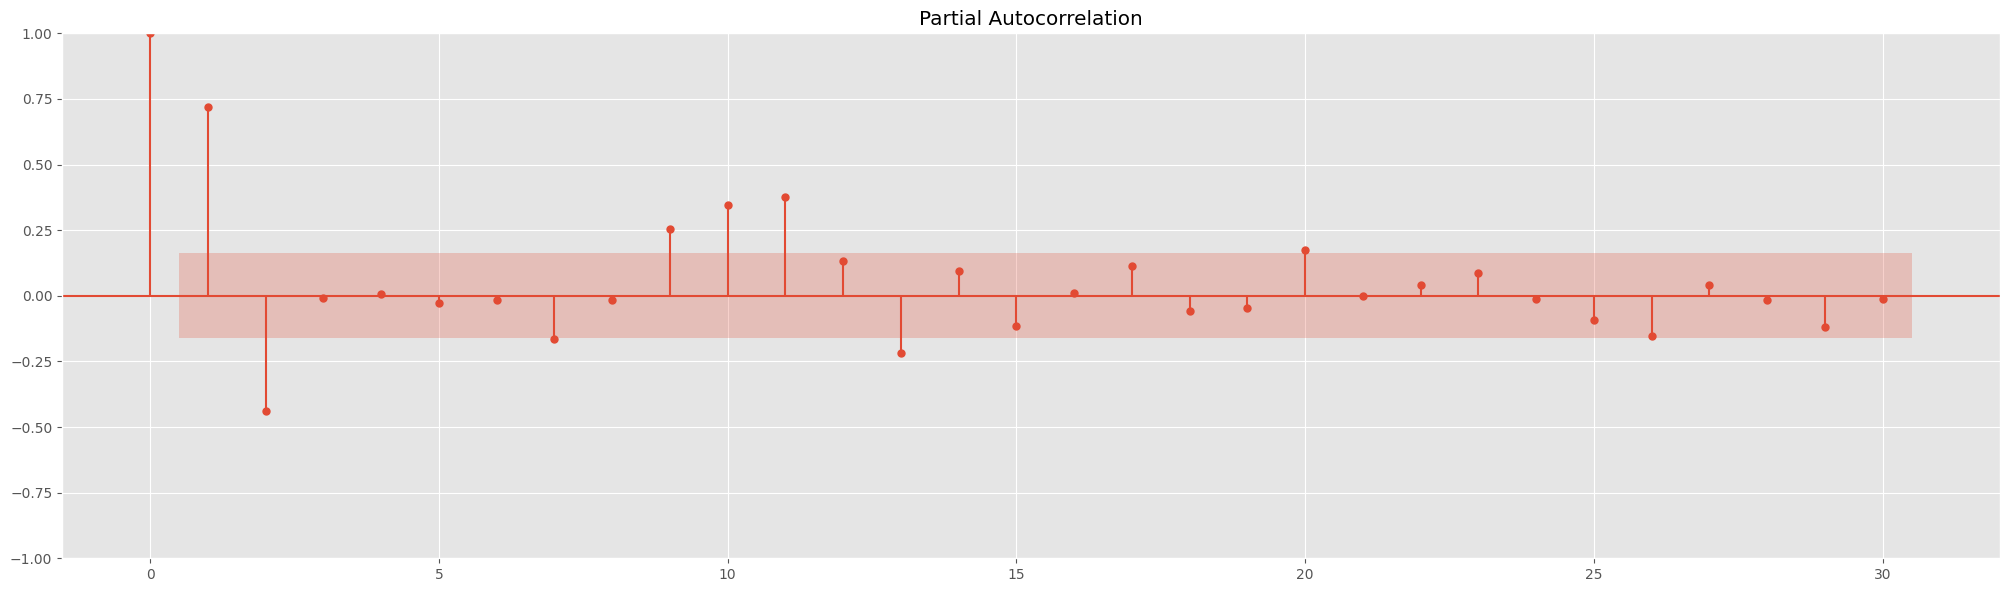

In [ ]:
fig = plt.figure(figsize=(25, 15))

ax = plt.subplot(211)

fig = sm.graphics.tsa.plot_pacf(ts_log, ax=ax, lags=30)

In [ ]:
Q = np.arange(1, 4)
P = 1
D = np.arange(2)
S = 12


Обучите на train модель с найденными (p,d,q), (P,D,Q,S),выведите на экран AIC - ответ округлите до сотых.

In [ ]:
order = best_params
best_full_params, best_full_score = None, float('inf')
for p in range(P + 1):
  for q in (Q):
    for d in D:
      order_s = (p, d, q, 12)
      full_model = sm.tsa.SARIMAX(train['quantity'], order=order, seasonal_order=order_s).fit()
      if full_model.aic < best_full_score:
        best_full_score, best_full_params = full_model.aic, order_s




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py

38.39034866840777 (11, 1, 3)


In [ ]:
print(np.round(best_full_score, 2), best_full_params)

23.62 (0, 1, 1, 12)


Сделайте прогноз на test.

In [ ]:
y_hat = full_model.predict(len(train) + len(val), len(train) + len(val) + len(test) - 1)

## Quiz

Нарисуйте правильный ответ на test и прогноз на test. Вычислите RMSE на test. Ответ округлите до сотых.

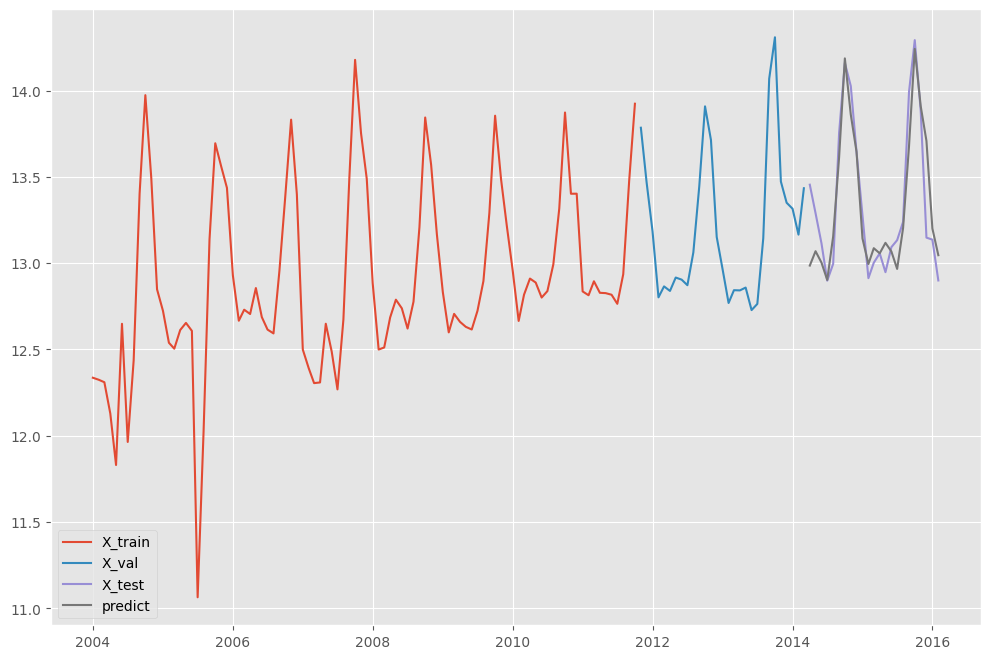

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(train.index.to_timestamp(), train['quantity'].values, label = 'X_train')

plt.plot(val.index.to_timestamp(), val['quantity'].values, label = 'X_val')

plt.plot(test.index.to_timestamp(), test['quantity'].values, label = 'X_test')

plt.plot(y_hat.index.to_timestamp(), y_hat.values, label = 'predict')

plt.legend(loc='best')


In [ ]:
rmse = np.sqrt(mean_squared_error(test['quantity'], y_hat))

In [ ]:
np.round(rmse, 2)

0.2

## Quiz

Удалось ли добиться с помощью настройки гиперпараметров SARIMAX модели с хорошей предсказательной силой?

## Бонус (не проверяется)

Попробуйте добавить экзогенных факторов в модель

In [ ]:
# ваш код здесь